In [1]:
import json
import collections
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import pandas as pd
import nltk
from sklearn import preprocessing
import time
from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [177]:
def release_base_dat():
    with open('data/processed_trumptwitterarchive.txt', 'r') as data_file:
        json_data = data_file.read()

    data = json.loads(json_data)

    times = [d['created_at'] for d in data]
    favorite_count = [d['favorite_count'] for d in data]
    retweet_count = [d['retweet_count'] for d in data]
    texts = [" ".join(d['processed_text']) for d in data]
    baseline_dat = pd.DataFrame({'created_time': pd.to_datetime(times), 
                                'favorite_count': favorite_count, 
                               'retweet_count': retweet_count, 
                                'texts': texts})

    top_20_words = ["china", "billion", "products", "democrats", "great","dollars","tariffs","country", "mueller","border",\
                     "president", "congressman", "people", "korea", "party", "years", "farmers", "going", "trade", "never"]

    for word in top_20_words:
        baseline_dat[word] = baseline_dat['texts'].apply(lambda x: 1 if word in x else 0)

    display(baseline_dat.head())
    baseline_dat.to_csv('data/baseline_data2.csv', index = False)

In [178]:
def merge_data(baseline_dir = 'data/baseline_data2.csv', 
               senti_dir = 'data/sentimentAnalysis/senti.csv', 
               spx_dir = 'data/all_cleaned_SPX_data.csv', 
               threshold = 1e-4, 
               m = 5):
    
    df1= pd.read_csv(baseline_dir)
    senti_data = pd.read_csv(senti_dir)
    df2 = senti_data[['time', 'positive_count', 'negative_count']]
    df = pd.merge(df1, df2, left_on = 'created_time', right_on='time').drop(['time'], axis=1)
    
    df['created_time'] = df['created_time'].apply(lambda x: pd.to_datetime(x))
    df['begin_time'] = df['created_time'].dt.floor('1min')
    df['end_time'] = df['begin_time'] + timedelta(minutes=m)
    
    data_econ = pd.read_csv('data/all_cleaned_SPX_data.csv')
    data_econ['datetime'] = pd.to_datetime(data_econ['datetime'], utc = True)
    df_econ = data_econ[['datetime', 'close']]
    
    df_merge1 = pd.merge(df, df_econ, left_on = 'begin_time', right_on='datetime').drop(['datetime'], axis=1)
    df_merge2 = pd.merge(df_merge1, df_econ, left_on = 'end_time', right_on='datetime').drop(['datetime'], axis=1)
    
    df_merge2['label'] = np.where(df_merge2['close_y'] > df_merge2['close_x'], 1, -1)
    medium1 = df_merge2['close_y'] / df_merge2['close_x'] > (1-threshold)
    medium2 = df_merge2['close_y'] / df_merge2['close_x'] < (1+threshold)
    medium = medium1 & medium2
    df_merge2['label'][medium] = 0
    
    df_all = df_merge2.drop(['created_time','begin_time','end_time', 'close_x','close_y', 'texts'], axis=1)
    
    return df_all
    

In [182]:
def baseline_models(df_all):
    df_all = df_all.copy()
    X_train, X_test, y_train, y_test =train_test_split(df_all.loc[:, df_all.columns != 'label'], 
                                                         df_all.label, test_size=0.2)
    
    scores = {}
    min_max_scaler = MinMaxScaler().fit(X_train)
    xtrain_scaled = min_max_scaler.transform(X_train.values)
    xtest_scaled = min_max_scaler.transform(X_test.values)
    X_train_scaled = pd.DataFrame(xtrain_scaled, columns = X_train.columns, index = X_train.index)
    X_test_scaled = pd.DataFrame(xtest_scaled, columns = X_test.columns, index = X_test.index)
    
    # logistic
    Logistic_model = LogisticRegression(C=100000)
    Logistic_model.fit(X_train_scaled, y_train)
    
    # logistic cv
    CV_logistic = LogisticRegressionCV()
    CV_logistic.fit(X_train_scaled, y_train)
    
    # knn
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    
    # Naive Bayes
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    gnb.fit(X_train_scaled, y_train)
    
    # randomforest
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(max_depth=20, n_estimators=1000)
    rf.fit(X_train_scaled,y_train)
    
    models = [Logistic_model, CV_logistic, gnb, knn, rf]
    names = ['logistic', "logistic_cv","Naive Bayes", "KNN", "randomforest"]
    
    for name, model in zip(names, models):
        scores[name] = [model.score(X_train_scaled, y_train), model.score(X_test_scaled, y_test)]
    
    return scores


In [183]:
def combined(threshold, m, times = 5):
    df_all = merge_data(m = m, threshold= threshold)
    
    import collections
    names = ['logistic', "logistic_cv","Naive Bayes", "KNN", "randomforest"]
    scores = collections.defaultdict(list)
    for i in range(times):
        temp = baseline_models(df_all)
        for n in names:
            scores[n].append(temp[n][1]) # only test score
            
    for n in names:
        scores[n] = np.mean(scores[n])
    return scores



In [184]:
from tqdm import tqdm
scores = {}
ms = range(1, 60, 3)
for m in tqdm(ms):
    scores[m] = combined(0, m) # if threshold = 0, then binary classification


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarnin

C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: F

C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: F

C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: F

C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)

 65%|██████▌   | 13/20 [10:11<05:23, 46.25s/it]C:\Users\for_y\Anaconda3\lib\site-

C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)

 80%|████████  | 16/20 [12:20<02:57, 44.49s/it]C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Fut


 95%|█████████▌| 19/20 [14:24<00:42, 42.23s/it]C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\for_y\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Fut

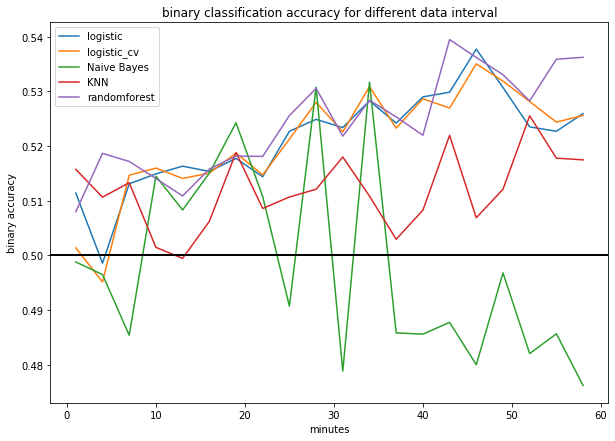

In [185]:
fig, ax = plt.subplots(1,1,figsize = (10,7))
names = ['logistic', "logistic_cv","Naive Bayes", "KNN", "randomforest"]
for n in names:
    test_scores = [score[n] for score in scores.values()]
    ax.plot(ms, test_scores, label = n)
    ax.set_xlabel('minutes')
    ax.set_ylabel('binary accuracy')
    ax.set_title('binary classification accuracy for different data interval')
    ax.axhline(y = 0.5, color = 'black')
ax.legend()

In [172]:
# To Jingyuan
ms = [5,10,15,20]
for m in ms:
    df_all = merge_data(threshold=0, m = m)
    df_all.to_csv('data/{}.csv'.format(m), index = False)

C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
